## CESM2 - LARGE ENSEMBLE (LENS2)

- This Notebooks intends to compute the heat balance in the South Atlantic, defined by the difference of the meridional heat transport from the northern and southern boundaries and the total surface heat flux (area integral) 

### Imports

In [1]:
import xarray as xr
import pandas as pd
import numpy as np 
import dask
import cf_xarray
import intake
import cftime
import nc_time_axis
import intake_esm
import matplotlib.pyplot as plt
import pop_tools
from dask.distributed import Client
from ncar_jobqueue import NCARCluster
import warnings, getpass, os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cmocean

### Dask

In [2]:
mem_per_worker = 90 # memory per worker in GB 
num_workers = 26 # number of workers
cluster = NCARCluster(cores=1, processes=1, memory=f'{mem_per_worker} GB',resource_spec=f'select=1:ncpus=1:mem={mem_per_worker}GB', walltime='6:00:00')
cluster.scale(num_workers)
client = Client(cluster)
print(client)
client

<Client: 'tcp://10.12.206.36:42449' processes=0 threads=0, memory=0 B>


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.36:42449,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Read in OGCM history file & MOC template file

In [3]:
catalog = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
)

/glade/u/home/mauricio/.local/lib/python3.8/site-packages/intake_esm/utils.py:96: DtypeWarning: Columns (5,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(catalog_path, **csv_kwargs), catalog_path


In [4]:
cat_subset = catalog.search(component='ocn',variable=['N_HEAT','SHF','TEMP','TEND_TEMP'],frequency='month_1')

In [5]:
# Load catalog entries for subset into a dictionary of xarray datasets
dset_dict_raw  = cat_subset.to_dataset_dict(zarr_kwargs={'consolidated': True}, storage_options={'anon': True})
print(f'\nDataset dictionary keys:\n {dset_dict_raw.keys()}')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'



Dataset dictionary keys:
 dict_keys(['ocn.ssp370.pop.h.cmip6.SHF', 'ocn.ssp370.pop.h.smbb.TEMP', 'ocn.historical.pop.h.smbb.TEMP', 'ocn.ssp370.pop.h.cmip6.TEND_TEMP', 'ocn.ssp370.pop.h.smbb.N_HEAT', 'ocn.historical.pop.h.cmip6.SHF', 'ocn.historical.pop.h.cmip6.TEND_TEMP', 'ocn.ssp370.pop.h.smbb.TEND_TEMP', 'ocn.historical.pop.h.smbb.SHF', 'ocn.ssp370.pop.h.cmip6.N_HEAT', 'ocn.historical.pop.h.cmip6.TEMP', 'ocn.historical.pop.h.cmip6.N_HEAT', 'ocn.ssp370.pop.h.smbb.SHF', 'ocn.ssp370.pop.h.cmip6.TEMP', 'ocn.historical.pop.h.smbb.N_HEAT', 'ocn.historical.pop.h.smbb.TEND_TEMP'])


### Concatenation of variables

In [7]:
fb=(['N_HEAT','SHF','TEMP','TEND_TEMP']) # Meridional heat transport [PW], total surface heat flux [W/m2], temperature [oC], and temperature tendency [oC/s]
pd=('historical','ssp370') # periods (historical and projection)
ff=('cmip6','smbb') # forcings
for ifb in range(0,len(fb)): # variables
    for iff in range(0,len(ff)): # forcing
        for ipd in range(0,len(pd)): # period
            st=f'ds_{pd[ipd]}_{ff[iff]}_{fb[ifb]} = dset_dict_raw[\'ocn.{pd[ipd]}.pop.h.{ff[iff]}.{fb[ifb]}\']'; exec(st); del st
        st=f'ds_{ff[iff]}_{fb[ifb]}=xr.combine_nested([ds_{pd[0]}_{ff[iff]}_{fb[ifb]},ds_{pd[1]}_{ff[iff]}_{fb[ifb]}],concat_dim=[\'time\'])'; exec(st); del st # period
    st=f'ds_{fb[ifb]}=xr.combine_nested([ds_{ff[0]}_{fb[ifb]},ds_{ff[1]}_{fb[ifb]}],concat_dim=[\'member_id\'])'; exec(st); del st # forcings
    print(f'{fb[ifb]}: Done!')

N_HEAT: Done!
SHF: Done!
TEMP: Done!
TEND_TEMP: Done!


### Import POP grid

In [8]:
pop_grid = pop_tools.get_grid('POP_gx1v7')
ds_SHF['TLONG'] = pop_grid.TLONG; ds_SHF['TLAT'] = pop_grid.TLAT
ds_TEMP['TLONG'] = pop_grid.TLONG; ds_TEMP['TLAT'] = pop_grid.TLAT
ds_TEND_TEMP['TLONG'] = pop_grid.TLONG; ds_TEND_TEMP['TLAT'] = pop_grid.TLAT

/glade/u/apps/opt/conda/envs/npl-2022b/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


### Calculate the difference in heat transport to latitudes closer to the equator and 34S
- We chose 34 instead of 34.5S, because at 34S we are sure that there is no water leakage south of Africa 

In [10]:
ilan = 0 # northernmost latitude
ilas = -34 # southernmost latitude
ds_N_HEAT_diff=((ds_N_HEAT.N_HEAT.isel(transport_reg=1).sel(lat_aux_grid=ilan,method='nearest'))-(ds_N_HEAT.N_HEAT.isel(transport_reg=1).sel(lat_aux_grid=ilas,method='nearest'))).sum(dim='transport_comp')

<xarray.DataArray 'N_HEAT' (member_id: 100, time: 3012)>
dask.array<sum-aggregate, shape=(100, 3012), dtype=float32, chunksize=(1, 120), chunktype=numpy.ndarray>
Coordinates:
    transport_regions  |S384 dask.array<chunksize=(), meta=np.ndarray>
  * time               (time) object 1850-02-01 00:00:00 ... 2101-01-01 00:00:00
  * member_id          (member_id) <U12 'r10i1181p1f1' ... 'r9i1171p1f2'

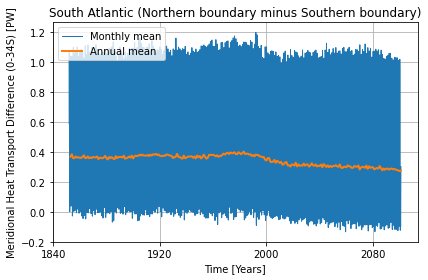

In [11]:
ds_N_HEAT_diff.sel(time=slice('1852-01-01','2100-12-31')).mean(dim='member_id').plot(linewidth=1,label='Monthly mean')
ds_N_HEAT_diff.sel(time=slice('1852-01-01','2100-12-31')).mean(dim='member_id').resample(time='1Y',closed='left').mean('time').plot(linewidth=2, label='Annual mean')
plt.grid()
plt.title('South Atlantic (Northern boundary minus Southern boundary)')
plt.xlabel('Time [Years]')
plt.ylabel('Meridional Heat Transport Difference (0-34S) [PW]')
plt.legend()
plt.tight_layout()
plt.show()

### Select the area to compute the heat balance

In [12]:
%%time
dask.config.set({"array.slicing.split_large_chunks": True})
ilon1, flon1, ilon2, flon2 = 307, 320, 0, 54 # longitude (initial, final) 

# Choose one the them
var='ULAT'; avar='UAREA' # T coordinates
#var='TLAT'; avar='TAREA' # U coordinates

# Area in cm2
st=f'ds_sa_{avar}=xr.combine_nested([[pop_grid.{avar}.where((pop_grid.{var} >= ilas) & (pop_grid.{var} <= ilan), drop=True).isel(nlon = slice(ilon1,flon1)),pop_grid.{avar}.where((pop_grid.{var} >= ilas) & (pop_grid.{var} <= ilan), drop=True).isel(nlon = slice(ilon2,flon2))]],concat_dim=[\'nlat\',\'nlon\'])'; exec(st); del st
st=f'ds_sa_{avar}.coords[\'nlon\'] = (ds_sa_{avar}.coords[\'nlon\'] + 180) % 360 - 180'; exec(st); del st 
st=f'ds_sa_{avar} = ds_sa_{avar}.sortby(ds_sa_{avar}.nlon)'; exec(st); del st

fb=(['SHF','TEMP','TEND_TEMP'])
for ifb in range(0,len(fb)):
    st=f'ds_sa_{fb[ifb]}=xr.combine_nested([[ds_{fb[ifb]}.{fb[ifb]}.where((ds_{fb[ifb]}.{fb[ifb]}.{var} >= ilas) & (ds_{fb[ifb]}.{fb[ifb]}.{var} <= ilan), drop=True).isel(nlon = slice(ilon1,flon1)),ds_{fb[ifb]}.{fb[ifb]}.where((ds_{fb[ifb]}.{fb[ifb]}.{var} >= ilas) & (ds_{fb[ifb]}.{fb[ifb]}.{var} <= ilan), drop=True).isel(nlon = slice(ilon2,flon2))]],concat_dim=[\'nlat\',\'nlon\'])'; exec(st); del st
    st=f'ds_sa_{fb[ifb]}.coords[\'nlon\'] = (ds_sa_{fb[ifb]}.coords[\'nlon\'] + 180) % 360 - 180'; exec(st); del st 
    st=f'ds_sa_{fb[ifb]} = ds_sa_{fb[ifb]}.sortby(ds_sa_{fb[ifb]}.nlon)'; exec(st); del st

    st=f'mask_ocean_{fb[ifb]} = 2 * np.ones((len(ds_sa_{fb[ifb]}.coords[\'nlat\']), len(ds_sa_{fb[ifb]}.coords[\'nlon\']))) * np.isfinite(ds_sa_{fb[ifb]}.isel(time=0,member_id=0))'; exec(st); del st  
    st=f'mask_land_{fb[ifb]} = 1 * np.ones((len(ds_sa_{fb[ifb]}.coords[\'nlat\']), len(ds_sa_{fb[ifb]}.coords[\'nlon\']))) * np.isnan(ds_sa_{fb[ifb]}.isel(time=0,member_id=0))'; exec(st); del st  
    st=f'mask_array_{fb[ifb]} = mask_ocean_{fb[ifb]} + mask_land_{fb[ifb]}'; exec(st); del st      
    
    if ifb>=1:
        st=f'area_new=ds_sa_{avar}.where(mask_array_{fb[ifb]}.isel(z_t=0) != 1.).load()'; exec(st); del st # Applying the basin masks in the area
        st=f'area_new=np.array([area_new]*len(mask_array_{fb[ifb]}.coords[\'z_t\']))'; exec(st) # Replicating the surface area for all as depths     
        st=f'area_array_{fb[ifb]}=xr.DataArray(area_new, dims=[\'z_t\', \'nlat\', \'nlon\'])'; exec(st) # We transform the array into a xarray so that there are no mismatches in the oprerations
        st=f'area_array_{fb[ifb]}=area_array_{fb[ifb]}.where(mask_array_{fb[ifb]} != 1.)'; exec(st) # The masks of what is ocean and what is continent or floor were built
    else:
        st=f'area_new=ds_sa_{avar}.where(mask_array_{fb[ifb]} != 1.).load()'; exec(st); del st # Applying the basin masks in the area
        st=f'area_array_{fb[ifb]}=xr.DataArray(area_new, dims=[\'nlat\', \'nlon\'])'; exec(st) # We transform the array into a xarray so that there are no mismatches in the oprerations
        st=f'area_array_{fb[ifb]}=area_array_{fb[ifb]}.where(mask_array_{fb[ifb]} != 1.)'; exec(st) # The masks of what is ocean and what is continent or floor were built
    print(f'{fb[ifb]}: Done!')

SHF: Done!
TEMP: Done!
TEND_TEMP: Done!
CPU times: user 10.6 s, sys: 337 ms, total: 10.9 s
Wall time: 49.2 s


### Transforming from cm to meter

In [13]:
ds_sa_dz_TEMP=ds_TEMP.dz*0.01 # cm to m
ds_sa_dz_TEND_TEMP=ds_TEND_TEMP.dz*0.01 # cm to m

In [14]:
ds_total_sa_SHF=(ds_sa_SHF*area_array_SHF*1e-4*1e-15).sum(dim=['nlat','nlon'],skipna=True) # Units PW 

### Here it was necessary to do the difference and not the sum of the terms to get the heat balance. This is because the SHF convection is positive to the ocean. The balance is given by every heat flux entering from the surface (positive direction of the z-axis) is equal to every flux leaving from the meridional heat transport (positive direction of the y-axis). The meirdional heat transport has a positive y-axis direction, but the SHF has not a negative z-axis direction. 

In [15]:
ds_sa_SHF_N_HEAT=ds_total_sa_SHF-ds_N_HEAT_diff 

### Converting the dimension z_t to meter

In [16]:
ds_sa_dz_TEMP['z_t']=ds_sa_dz_TEMP['z_t']*0.01 # cm to m
ds_sa_TEMP['z_t']=ds_sa_TEMP['z_t']*0.01 # cm to m
ds_sa_dz_TEND_TEMP['z_t']=ds_sa_dz_TEND_TEMP['z_t']*0.01 # cm to m
ds_sa_TEND_TEMP['z_t']=ds_sa_TEND_TEMP['z_t']*0.01 # cm to m

### Let's compute the stored heat to compare with the heat stored due to the difference between the heat fluxes
- We will do this in two ways: by the mean temperature and by the trend temperature (more appropriate since we are dealing with instantaneous measurements)

##### 1- Monthly temperature 

###### Equation: $$\rm{HS = \uprho_\uptheta~C_p~\int_{z_2}^{z_1}\uptheta_{(z)}'~dz},$$
###### where:
###### * HS is heat storage ($\rm{J~m^{-2}}$),
###### * $\uprho$ is the density of sea water (1026 $\rm{kg~m^{-3}}$),
###### * $\rm{C_p}$ is the specific heat of sea water (3996 $\rm{J~kg^{-1}~K^{-1}}$) from the model,
###### * $\rm{z}$ is the depth limit on the calculation in meters,
###### * and $\uptheta$' is the potential temperature monthly anomaly (successor month minus previous month) at each depth in degress Kelvin. 

In [18]:
rho = 1026 # kg/m^3
c_p = 3996 # J/(kg K) - I used the same amount of specific heat used by the model
ds_sa_TEMP_anom=ds_sa_TEMP.diff(dim='time') # oC

##### Integral

In [ ]:
%%time
ds_sa_HS=(((ds_sa_TEMP_anom*ds_sa_dz_TEMP).sum(dim='z_t'))*rho*c_p).load() # J m-2
#ds_sa_HS=(((ds_sa_TEMP_anom.mean(dim='member_id')*ds_sa_dz_TEMP.mean(dim='member_id')).sum(dim='z_t'))*rho*c_p).load() # J m-2
#sa_ds_HS=sa_ds_HS.where(mask_SHF != 9999.).load()
#sa_ds_HS.mean(dim='time').plot()

In [ ]:
ds_sa_HS=(ds_sa_HS*area_sa*1e-4).sum(dim=['nlon','nlat']) # J

##### Time

In [ ]:
%%time
# Selecting the number of days each month has
dt = np.empty((len(ds_sa_N_HEAT.time_bound.coords['time']))) * np.nan
for it in range(0,len(ds_sa_N_HEAT.time_bound.coords['time'])):
    dt[it]=np.abs(ds_sa_N_HEAT.time_bound.isel(member_id=0,time=it,d2=0).values-ds_sa_N_HEAT.time_bound.isel(member_id=0,time=it,d2=1).values).days

In [ ]:
# 1 month = 60*60*24s
# 1 W = 1e-15 PW
ds_sa_HS_PW=ds_sa_HS*(1e-15)/(60*60*24*dt[0:-1]) # PW 

In [ ]:
%%time
Total_SHF=Total_SHF.mean(dim='member_id').resample(time='1Y',closed='left').mean('time').sel(time=slice('1851-01-01','2100-12-31'))
ds_N_HEAT_diff=ds_N_HEAT_diff.mean(dim='member_id').resample(time='1Y',closed='left').mean('time').sel(time=slice('1851-01-01','2100-12-31'))*-1
SHF_MHT_diff=SHF_MHT_diff.mean(dim='member_id').resample(time='1Y',closed='left').mean('time').sel(time=slice('1851-01-01','2100-12-31'))
sa_ds_HS_PW=sa_ds_HS_PW.resample(time='1Y',closed='left').mean('time').sel(time=slice('1851-01-01','2100-12-31'))

In [ ]:
plt.figure(figsize=(14, 6))
Total_SHF.plot(linewidth=1, label='SHF')
ds_N_HEAT_diff.plot(linewidth=1, label='MHT')
SHF_MHT_diff.plot(linewidth=1,label='SHF+MHT')
sa_ds_HS_PW.plot(linewidth=1,label='HS')
plt.title('South Atlantic Ocean')
plt.xlabel('Time [Years]')
plt.ylabel('Annual average heat balance [PW]')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
Total_SHF

In [ ]:
# Normalized
plt.figure(figsize=(14, 6))
((Total_SHF-np.min(Total_SHF))/(np.max(Total_SHF)-np.min(Total_SHF))).plot(linewidth=1, label='SHF')
((ds_N_HEAT_diff-np.min(ds_N_HEAT_diff))/(np.max(ds_N_HEAT_diff)-np.min(ds_N_HEAT_diff))).plot(linewidth=1, label='MHT')
((SHF_MHT_diff-np.min(SHF_MHT_diff))/(np.max(SHF_MHT_diff)-np.min(SHF_MHT_diff))).plot(linewidth=1, label='SHF+MHT')
((sa_ds_HS_PW-np.min(sa_ds_HS_PW))/(np.max(sa_ds_HS_PW)-np.min(sa_ds_HS_PW))).plot(linewidth=1, label='HS')
plt.xlabel('Time [Years]')
plt.ylabel('Annual average heat balance [PW]')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

### Concluding remarks

### What are the next steps?

### Questions: 